# Classification

In [1]:
using MLJ, StableRNGs
import DecisionTree as DT

include("pubh.jl");

In [2]:
using AlgebraOfGraphics, CairoMakie, MakieThemes
CairoMakie.activate!(type = "svg")
AoG = AlgebraOfGraphics; data = AoG.data
set_theme!(ggthemr(:light))

In [3]:
@rlibrary readr
@rlibrary epitools
@rimport pubh

## Data

::: callout-tip
## Example

Fisher’s iris dataset on measurements for three species of iris.
:::

In [4]:
iris = rcopy(R"datasets::iris")
iris |> schema

┌──────────────┬───────────────┬──────────────────────────────────┐
│ names        │ scitypes      │ types                            │
├──────────────┼───────────────┼──────────────────────────────────┤
│ Sepal_Length │ Continuous    │ Float64                          │
│ Sepal_Width  │ Continuous    │ Float64                          │
│ Petal_Length │ Continuous    │ Float64                          │
│ Petal_Width  │ Continuous    │ Float64                          │
│ Species      │ Multiclass{3} │ CategoricalValue{String, UInt32} │
└──────────────┴───────────────┴──────────────────────────────────┘


We `unpack` the data to define *response* and *explanatory* variables:

In [5]:
y, X = unpack(iris, ==(:Species)); 

In [6]:
X |> head

Row,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width
,Float64,Float64,Float64,Float64
1,5.1,3.5,1.4,0.2
2,4.9,3.0,1.4,0.2
3,4.7,3.2,1.3,0.2
4,4.6,3.1,1.5,0.2
5,5.0,3.6,1.4,0.2


### Data sppliting

In [7]:
rng = StableRNG(566)
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=rng);

## Pruned Trees

### Model

In [8]:
using MLJDecisionTreeInterface

In [9]:

dtc = @load DecisionTreeClassifier pkg=DecisionTree verbosity=0
pruned_model = dtc(max_depth=2)
pruned_mach = machine(pruned_model, X, y)

untrained Machine; caches model-specific representations of data
  model: DecisionTreeClassifier(max_depth = 2, …)
  args: 
    1:	Source @712 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @055 ⏎ AbstractVector{Multiclass{3}}


In [10]:
fit!(pruned_mach, rows=train);

┌ Info: Training machine(DecisionTreeClassifier(max_depth = 2, …), …).
└ @ MLJBase /Users/josie/.julia/packages/MLJBase/fEiP2/src/machines.jl:492


### Visualisation

In [11]:
fitted_params(pruned_mach).tree

Petal_Width < 0.75
├─ setosa (38/38)
└─ Petal_Width < 1.7
   ├─ versicolor (33/35)
   └─ virginica (32/32)


In [12]:
pruned_mach |> feature_importances

4-element Vector{Pair{Symbol, Float64}}:
  :Petal_Width => 1.0
 :Sepal_Length => 0.0
  :Sepal_Width => 0.0
 :Petal_Length => 0.0

### Performance

In [13]:
pruned_ŷ = MLJ.predict(pruned_mach, rows=test)
pruned_ȳ = predict_mode(pruned_mach, rows=test);

In [14]:
cross_entropy(pruned_ŷ, y[test]) |> mean |> r3

1.013

In [15]:
misclassification_rate(
	string.(pruned_ȳ), 
	string.(y[test])
) |> r3

0.089

In [16]:
accuracy(
	string.(pruned_ȳ), 
	string.(y[test])
) |> r3

0.911

In [17]:
DT.confusion_matrix(
  string.(pruned_ȳ), 
  string.(y[test])
)

3×3 Matrix{Int64}:
 12   0   0
  0  16   3
  0   1  13

Classes:  ["setosa", "versicolor", "virginica"]
Matrix:   
Accuracy: 0.9111111111111111
Kappa:    0.8650674662668664

::: callout-note
We can also look at the confussion matrix with `epitable`.
:::

In [18]:
epitable(
  string.(pruned_ȳ), 
  string.(y[test])
)

RObject{IntSxp}
            Outcome
Predictor    setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         16         3
  virginica       0          1        13


We use the frequencies from the confussion matrix to calculate specificity and sensitivity for correctly classifying observations as *setosa*.

In [19]:
pubh.diag_test2(12, 0, 0, 16+3+1+13) |> rcopy


          Outcome +    Outcome -      Total
Test +           12            0         12
Test -            0           33         33
Total            12           33         45

Point estimates and 95% CIs:
--------------------------------------------------------------
Apparent prevalence *                  0.27 (0.15, 0.42)
True prevalence *                      0.27 (0.15, 0.42)
Sensitivity *                          1.00 (0.74, 1.00)


Specificity *                          1.00 (0.89, 1.00)
Positive predictive value *            1.00 (0.74, 1.00)
Negative predictive value *            1.00 (0.89, 1.00)
Positive likelihood ratio              Inf (NaN, Inf)
Negative likelihood ratio              0.00 (0.00, NaN)
False T+ proportion for true D- *      0.00 (0.00, 0.11)
False T- proportion for true D+ *      0.00 (0.00, 0.26)
False T+ proportion for T+ *           0.00 (0.00, 0.26)
False T- proportion for T- *           0.00 (0.00, 0.11)
Correctly classified proportion *      1.00 (0.92, 1.00)
--------------------------------------------------------------
* Exact CIs



When we have many categories, it is easy to construct the data frame, and from that data frame, create binary variables and then construct the corresponding confussion matrix.

In [20]:
prune_df = DataFrame(
  hcat(
    string.(pruned_ȳ),
    string.(y[test])
  ),
  [:pred, :obs]
);

In [21]:
prune_df.pred_bin = prune_df.pred .== "setosa"
prune_df.obs_bin = prune_df.obs .== "setosa";

In [22]:
epitable(prune_df.pred_bin, prune_df.obs_bin, rev="both")

RObject{IntSxp}
         Outcome
Predictor TRUE FALSE
    TRUE    12     0
    FALSE    0    33


In [23]:
pubh.diag_test2(12, 0, 0, 33) |> rcopy


          Outcome +    Outcome -      Total
Test +           12            0         12
Test -            0           33         33
Total            12           33         45

Point estimates and 95% CIs:
--------------------------------------------------------------
Apparent prevalence *                  0.27 (0.15, 0.42)
True prevalence *                      0.27 (0.15, 0.42)
Sensitivity *                          1.00 (0.74, 1.00)
Specificity *                          1.00 (0.89, 1.00)
Positive predictive value *            1.00 (0.74, 1.00)
Negative predictive value *            1.00 (0.89, 1.00)
Positive likelihood ratio              Inf (NaN, Inf)
Negative likelihood ratio              0.00 (0.00, NaN)
False T+ proportion for true D- *      0.00 (0.00, 0.11)
False T- proportion for true D+ *      0.00 (0.00, 0.26)
False T+ proportion for T+ *           0.00 (0.00, 0.26)
False T- proportion for T- *           0.00 (0.00, 0.11)
Correctly classified proportion *      1.00 (0.92,

In [24]:
epitable(
  string.(pruned_ȳ), 
  string.(y[test])
)

RObject{IntSxp}
            Outcome
Predictor    setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         16         3
  virginica       0          1        13


## Decision Trees

### Model

In [25]:
dt_model = dtc(merge_purity_threshold=0.9)
dt_mach = machine(dt_model, X, y)

untrained Machine; caches model-specific representations of data
  model: DecisionTreeClassifier(max_depth = -1, …)
  args: 
    1:	Source @395 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @147 ⏎ AbstractVector{Multiclass{3}}


In [26]:
fit!(dt_mach, rows=train);

┌ Info: Training machine(DecisionTreeClassifier(max_depth = -1, …), …).
└ @ MLJBase /Users/josie/.julia/packages/MLJBase/fEiP2/src/machines.jl:492


### Visualisation

In [27]:
fitted_params(dt_mach).tree

Petal_Width < 0.75
├─ setosa (38/38)
└─ Petal_Width < 1.7
   ├─ Petal_Length < 4.95
   │  ├─ versicolor (32/32)
   │  └─ Petal_Width < 1.55
   │     ├─ virginica (2/2)
   │     └─ versicolor (1/1)
   └─ virginica (32/32)


In [28]:
dt_mach |> feature_importances

4-element Vector{Pair{Symbol, Float64}}:
  :Petal_Width => 0.9500106985559343
 :Petal_Length => 0.049989301444065756
 :Sepal_Length => 0.0
  :Sepal_Width => 0.0

### Performance

In [29]:
dt_ŷ = MLJ.predict(dt_mach, rows=test)
dt_ȳ = predict_mode(dt_mach, rows=test);

In [30]:
cross_entropy(dt_ŷ, y[test]) |> mean |> r3

2.403

In [31]:
misclassification_rate(
	string.(dt_ȳ), 
	string.(y[test])
) |> r3

0.067

In [32]:
accuracy(
	string.(dt_ȳ), 
	string.(y[test])
) |> r3

0.933

In [33]:
DT.confusion_matrix(
	string.(dt_ȳ), 
	string.(y[test])
)

3×3 Matrix{Int64}:
 12   0   0
  0  16   2
  0   1  14

Classes:  ["setosa", "versicolor", "virginica"]
Matrix:   
Accuracy: 0.9333333333333333
Kappa:    0.898876404494382

In [34]:
epitable(
	string.(dt_ȳ), 
	string.(y[test])
)

RObject{IntSxp}
            Outcome
Predictor    setosa versicolor virginica
  setosa         12          0         0
  versicolor      0         16         2
  virginica       0          1        14


In [35]:
pubh.diag_test2(12, 0, 0, 16+2+1+14)


          Outcome +    Outcome -      Total
Test +           12            0         12
Test -            0           33         33
Total            12           33         45

Point estimates and 95% CIs:
--------------------------------------------------------------
Apparent prevalence *                  0.27 (0.15, 0.42)
True prevalence *                      0.27 (0.15, 0.42)
Sensitivity *                          1.00 (0.74, 1.00)
Specificity *                          1.00 (0.89, 1.00)
Positive predictive value *            1.00 (0.74, 1.00)
Negative predictive value *            1.00 (0.89, 1.00)
Positive likelihood ratio              Inf (NaN, Inf)
Negative likelihood ratio              0.00 (0.00, NaN)
False T+ proportion for true D- *      0.00 (0.00, 0.11)
False T- proportion for true D+ *      0.00 (0.00, 0.26)
False T+ proportion for T+ *           0.00 (0.00, 0.26)
False T- proportion for T- *           0.00 (0.00, 0.11)
Correctly classified proportion *      1.00 (0.92,

RObject{NilSxp}
NULL


## Random Forests

### Model

In [36]:
rfc = @load RandomForestClassifier pkg=DecisionTree verbosity=0
forest = rfc(
  	n_subfeatures = 2,
  	n_trees = 10,
  	sampling_fraction = 0.5,
  	max_depth = 6
)
forest_mach = machine(forest, X, y)

untrained Machine; caches model-specific representations of data
  model: RandomForestClassifier(max_depth = 6, …)
  args: 
    1:	Source @427 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @001 ⏎ AbstractVector{Multiclass{3}}


In [37]:
fit!(forest_mach, rows=train);

┌ Info: Training machine(RandomForestClassifier(max_depth = 6, …), …).
└ @ MLJBase /Users/josie/.julia/packages/MLJBase/fEiP2/src/machines.jl:492


In [38]:
fitted_params(forest_mach)

(forest = Ensemble of Decision Trees
Trees:      10
Avg Leaves: 5.4
Avg Depth:  4.1,)

In [39]:
forest_mach |> feature_importances

4-element Vector{Pair{Symbol, Float64}}:
 :Petal_Length => 0.496363114309921
  :Petal_Width => 0.39513958627422147
 :Sepal_Length => 0.09423840931488503
  :Sepal_Width => 0.014258890100972482

### Performance

In [40]:
forest_ŷ = MLJ.predict(forest_mach, rows=test)
forest_ȳ = predict_mode(forest_mach, rows=test);

In [41]:
cross_entropy(forest_ŷ, y[test]) |> mean |> r3

0.151

In [42]:
misclassification_rate(
	string.(forest_ȳ), 
	string.(y[test])
) |> r3

0.067

In [43]:
accuracy(
	string.(forest_ȳ), 
	string.(y[test])
) |> r3

0.933

In [44]:
DT.confusion_matrix(
	string.(forest_ȳ), 
	string.(y[test])
)

3×3 Matrix{Int64}:
 12   0   0
  0  15   1
  0   2  15

Classes:  ["setosa", "versicolor", "virginica"]
Matrix:   
Accuracy: 0.9333333333333333
Kappa:    0.8990276738967838

## Linear Discriminant Analysis

### Model

In [45]:
using MLJMultivariateStatsInterface

In [46]:
LDA = @load LDA pkg=MultivariateStats verbosity=0
lda_model = LDA()
lda_mach = machine(lda_model, X, y)

untrained Machine; caches model-specific representations of data
  model: LDA(method = gevd, …)
  args: 
    1:	Source @835 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @151 ⏎ AbstractVector{Multiclass{3}}


In [47]:
fit!(lda_mach, rows=train);

┌ Info: Training machine(LDA(method = gevd, …), …).
└ @ MLJBase /Users/josie/.julia/packages/MLJBase/fEiP2/src/machines.jl:492


In [48]:
fitted_params(lda_mach)

(classes = ["virginica", "versicolor", "setosa"],
 projection_matrix = [-0.06645469050942428 -0.04922272823956614; -0.1504951632177605 -0.14534646469948417; 0.2210436659376197 0.17510302165014127; 0.32784746705091267 -0.4039765375288937],)

### Visualisation

In [49]:
lda_x = MLJ.transform(lda_mach)
lda_x |> size

(150, 2)

In [50]:
lda_x |> head

Row,x1,x2
,Float64,Float64
1,-0.490621,-0.5954
2,-0.402083,-0.512882
3,-0.440995,-0.549617
4,-0.375092,-0.495139
5,-0.499025,-0.605012


In [51]:
lda_df = DataFrame(
	PC1 = lda_x.x1,
	PC2 = lda_x.x2,
	Species = string.(y)
)

lda_df |> head

Row,PC1,PC2,Species
,Float64,Float64,String
1,-0.490621,-0.5954,setosa
2,-0.402083,-0.512882,setosa
3,-0.440995,-0.549617,setosa
4,-0.375092,-0.495139,setosa
5,-0.499025,-0.605012,setosa


┌ Warning: Keyword argument `bgcolor` is deprecated, use `backgroundcolor` instead.
└ @ Makie /Users/josie/.julia/packages/Makie/RgxaV/src/makielayout/blocks/legend.jl:23


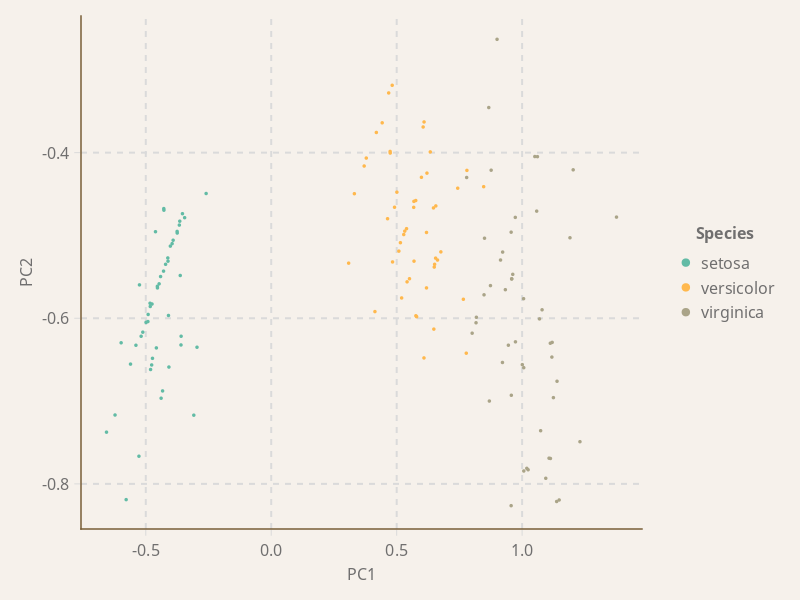

In [52]:
#| label: fig-fig1
#| fig-cap: "Principal components used to classify the iris data set."
#| warning: false
data(lda_df) *
mapping(
    :PC1, :PC2, color=:Species
) *
visual(Scatter, markersize=5) |>
draw

### Performance

In [53]:
lda_ŷ = MLJ.predict(lda_mach, rows=test)
lda_ȳ = predict_mode(lda_mach, rows=test);

In [54]:
cross_entropy(lda_ŷ, y[test]) |> mean |> r3

0.639

In [55]:
misclassification_rate(
	string.(lda_ȳ), 
	string.(y[test])
) |> r3

0.022

In [56]:
accuracy(
	string.(lda_ȳ), 
	string.(y[test])
) |> r3

0.978

In [57]:
DT.confusion_matrix(string.(lda_ȳ), string.(y[test]))

3×3 Matrix{Int64}:
 12   0   0
  0  16   0
  0   1  16

Classes:  ["setosa", "versicolor", "virginica"]
Matrix:   
Accuracy: 0.9777777777777777
Kappa:    0.9663425579655945